In [1]:
import wandb
wandb.login(key='fac5cd7f576f5d6d2591b0e77385c09a7922b210')
wandb.init(
    # set the wandb project where this run will be logged
    project="SMAI_ASSIGNMENT3_Part2_4",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.04,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": 10,
    }
)

/Users/swayam/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/Users/swayam/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
wandb: Currently logged in as: swayamagrawal1004. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command l

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, hamming_loss

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x) ** 2

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def sgd_optimizer(parameters, gradients, learning_rate, batch_size):
    for param, grad in zip(parameters, gradients):
        param -= learning_rate * grad

def batch_gradient_descent(parameters, gradients, learning_rate, batch_size):
    for param, grad in zip(parameters, gradients):
        param -= (learning_rate / batch_size) * grad

def mini_batch_gradient_descent(parameters, gradients, learning_rate, batch_size):
    for param, grad in zip(parameters, gradients):
        param -= learning_rate * grad

class MLPClassifierMultiLabel:
    def __init__(self, input_size, hidden_layers, output_size, learning_rate=0.01, activation_function=sigmoid, optimizer=sgd_optimizer):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.learning_rate = learning_rate

        self.activation_function = activation_function
        if (activation_function == sigmoid):
            self.activation_derivative = sigmoid_derivative
        if (activation_function == tanh):
            self.activation_derivative = tanh_derivative
        if (activation_function == relu):
            self.activation_derivative = relu_derivative

        self.optimizer = optimizer
        self.weights, self.biases = self.initialize_weights_and_biases()

    def initialize_weights_and_biases(self):
        layer_sizes = [self.input_size] + self.hidden_layers + [self.output_size]
        weights = [np.random.randn(layer_sizes[i], layer_sizes[i + 1]) for i in range(len(layer_sizes) - 1)]
        biases = [np.zeros(layer_size) for layer_size in layer_sizes[1:]]
        return weights, biases

    def forward_propagation(self, x):
        activations = [x]
        weighted_inputs = []

        for i in range(len(self.weights)):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            weighted_inputs.append(z)
            if i == len(self.weights) - 1:
                a = sigmoid(z)
            else:
                a = self.activation_function(z)
            activations.append(a)

        return activations, weighted_inputs

    def backward_propagation(self, x, y, activations, weighted_inputs):
        m = x.shape[0]
        gradients = [np.zeros_like(weight) for weight in self.weights]
        bias_gradients = [np.zeros_like(bias) for bias in self.biases]

        delta = (activations[-1] - y) * self.activation_derivative(activations[-1])

        for i in range(len(self.weights) - 1, -1, -1):
            gradients[i] = np.dot(activations[i].T, delta) / m
            bias_gradients[i] = np.sum(delta, axis=0) / m
            if i == 0:
                continue
            delta = np.dot(delta, self.weights[i].T) * self.activation_derivative(activations[i])

        self.biases = [bias - self.learning_rate * bias_gradient for bias, bias_gradient in zip(self.biases, bias_gradients)]
        return gradients
    
    def binary_cross_entropy_loss(self, y_true, y_pred):
        epsilon = 1e-15  
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  
        loss = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        return np.mean(loss) 

    def train(self, x_train, y_train, epochs, batch_size=None):
        train_losses = []
        for epoch in range(epochs):
            self.n_samples = x_train.shape[0]
            shuffle = np.random.permutation(self.n_samples)
            train_loss = 0
            X_batches = np.array_split(x_train[shuffle], self.n_samples / batch_size)
            Y_batches = np.array_split(y_train[shuffle], self.n_samples / batch_size)
            for batch_x, batch_y in zip(X_batches, Y_batches):
                activations, weighted_inputs = self.forward_propagation(batch_x)
                train_loss += self.binary_cross_entropy_loss(batch_y, activations[-1])
                gradients = self.backward_propagation(batch_x, batch_y, activations, weighted_inputs)
                self.optimizer(self.weights, gradients, self.learning_rate, batch_size)

            train_loss = (train_loss / len(X_batches))
            train_losses.append(train_loss)
        self.train_lossarr = train_losses

    def update_weights_and_biases(self, gradients):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * gradients[i]

    def pred_wrapper(self, x, threshold):
        activations, _ = self.forward_propagation(x)
        predictions = (activations[-1] > threshold).astype(int)
        return predictions

    def predict(self, x):
        activations, _ = self.forward_propagation(x)
        predictions = (activations[-1] > 0.4).astype(int)
        return predictions

    def calc_loss(self, x, y):
        activations, _ = self.forward_propagation(x)
        loss = self.binary_cross_entropy_loss(y, activations[-1])
        return loss

In [19]:
dataset = pd.read_csv('advertisement.csv')
y = dataset['labels'].tolist() 
X = dataset.drop(columns=['labels'])
y = np.array(y)

# drop the city column from X
X = X.drop(columns=['city'])

numerical_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns
bool_features = X.select_dtypes(include=["bool"]).columns

X[bool_features] = X[bool_features].astype(int)

for feature in categorical_features:
    encoder_ = LabelEncoder()
    X[feature] = encoder_.fit_transform(X[feature])

scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

X = np.array(X)
mlb = MultiLabelBinarizer()
y_binarized = mlb.fit_transform([y_label.split() for y_label in y])

X_train, X_temp, y_train, y_temp = train_test_split(X, y_binarized, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

input_size = X_train.shape[1]
hidden_layers = [6, 6] 
output_size = y_train.shape[1]
learning_rate = 0.007
epochs = 100
batch_size = 20

activation_functions = {
    "sigmoid": (sigmoid, sigmoid_derivative),
    "tanh": (tanh, tanh_derivative),
    "relu": (relu, relu_derivative)
}

optimizers = {
    "sgd": sgd_optimizer,
    "batch": batch_gradient_descent,
    "mini-batch": mini_batch_gradient_descent
}

results = []

In [23]:
for activation_name, (activation_function, activation_derivative) in activation_functions.items():
    for optimizer_name, optimizer_func in optimizers.items():

        clf = MLPClassifierMultiLabel(input_size, hidden_layers, output_size, learning_rate, activation_function, optimizer_func)
        clf.train(X_train, y_train, epochs, batch_size)

        y_pred = clf.pred_wrapper(X_val, 0.4)

        hamming_score = hamming_loss(y_val, y_pred)
        accuracy = (1 - hamming_score)
        precision = precision_score(y_val, y_pred, average='micro')
        recall = recall_score(y_val, y_pred, average='micro')
        f1 = f1_score(y_val, y_pred, average='micro')
        accuracy_sklearn_metric = accuracy_score(y_val, y_pred)

        results.append({
            "Activation": activation_name,
            "Optimizer": optimizer_name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1": f1
        })

results = sorted(results, key=lambda x: x["Accuracy"], reverse=True)
for result in results:
    print(f"Activation: {result['Activation']}, Optimizer: {result['Optimizer']}")
    print(f"Accuracy: {result['Accuracy']:.2f}")
    print(f"Precision: {result['Precision']:.2f}")
    print(f"Recall: {result['Recall']:.2f}")
    print(f"F1 Score: {result['F1']:.2f}\n")

Activation: relu, Optimizer: mini-batch
Accuracy: 0.69
Precision: 0.67
Recall: 0.03
F1 Score: 0.06

Activation: relu, Optimizer: batch
Accuracy: 0.68
Precision: 0.86
Recall: 0.02
F1 Score: 0.03

Activation: relu, Optimizer: mini-batch
Accuracy: 0.68
Precision: 0.59
Recall: 0.03
F1 Score: 0.06

Activation: relu, Optimizer: mini-batch
Accuracy: 0.68
Precision: 1.00
Recall: 0.00
F1 Score: 0.01

Activation: relu, Optimizer: sgd
Accuracy: 0.68
Precision: 0.43
Recall: 0.01
F1 Score: 0.02

Activation: relu, Optimizer: batch
Accuracy: 0.68
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Activation: tanh, Optimizer: sgd
Accuracy: 0.68
Precision: 0.47
Recall: 0.08
F1 Score: 0.14

Activation: relu, Optimizer: sgd
Accuracy: 0.68
Precision: 0.41
Recall: 0.03
F1 Score: 0.06

Activation: relu, Optimizer: batch
Accuracy: 0.67
Precision: 0.36
Recall: 0.02
F1 Score: 0.04

Activation: relu, Optimizer: sgd
Accuracy: 0.67
Precision: 0.35
Recall: 0.02
F1 Score: 0.04

Activation: relu, Optimizer: batch
Accuracy

In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, hamming_loss
import wandb
import itertools
import matplotlib.pyplot as plt

In [25]:
learning_rates = [0.01, 0.05, 0.1]
epochs_values = [50, 100, 150]
hidden_layers_values = [[32, 16], [6, 6], [8, 6]]

results = []
accuracy_trend = []
labels = []

# Iterate over hyperparameter combinations
for lr, epochs, hidden_layers in itertools.product(learning_rates, epochs_values, hidden_layers_values):

    clf = MLPClassifierMultiLabel(input_size, hidden_layers, output_size, lr, tanh, sgd_optimizer)
    clf.train(X_train, y_train, epochs, batch_size)

    y_pred = clf.pred_wrapper(X_val, 0.5)

    hamming_score = hamming_loss(y_val, y_pred)
    accuracy = (1 - hamming_score)
    precision = precision_score(y_val, y_pred, average='micro')
    recall = recall_score(y_val, y_pred, average='micro')
    f1 = f1_score(y_val, y_pred, average='micro')

    results.append({
        "Learning Rate": lr,
        "Epochs": epochs,
        "Hidden Layers": hidden_layers,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    })

    accuracy_trend.append(accuracy)
    labels.append(f"LR: {lr}, Epochs: {epochs}, Hidden Layers: {hidden_layers}")

results_df = pd.DataFrame(results)
sorted_results = results_df.sort_values(by="Accuracy", ascending=False)

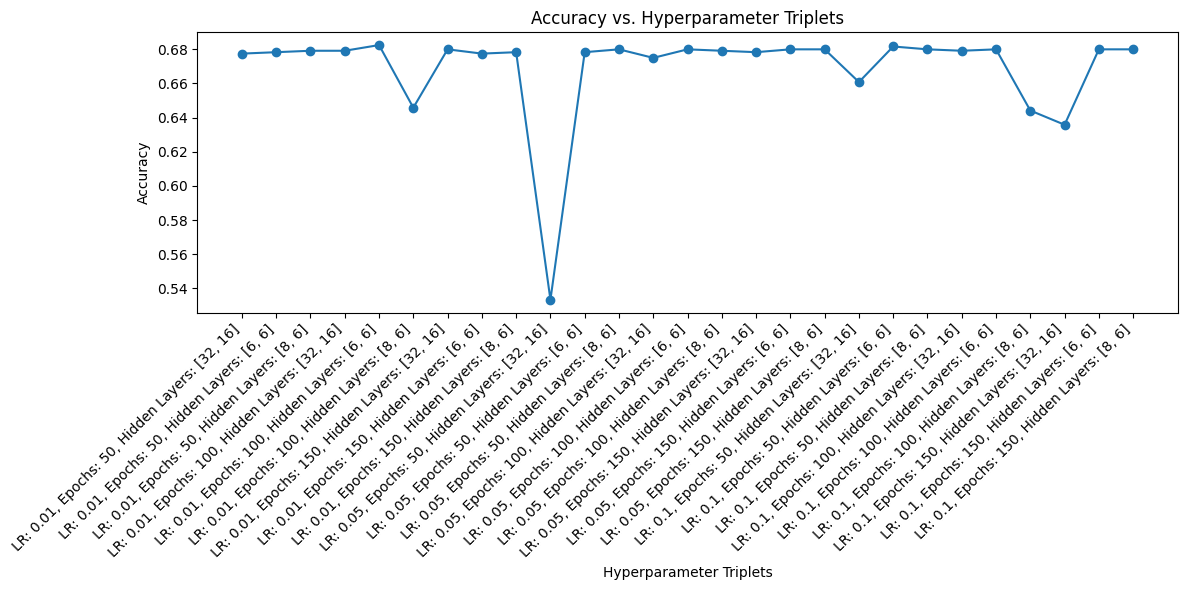

Best Model Parameters:
Learning Rate        0.01
Epochs                100
Hidden Layers      [6, 6]
Accuracy           0.6825
Precision        0.714286
Recall           0.013021
F1               0.025575
Name: 4, dtype: object
Scores for All Hyperparameter Combinations:
    Learning Rate  Epochs Hidden Layers  Accuracy  Precision    Recall  \
4            0.01     100        [6, 6]  0.682500   0.714286  0.013021   
19           0.10      50        [6, 6]  0.681667   0.666667  0.010417   
13           0.05     100        [6, 6]  0.680000   0.000000  0.000000   
11           0.05      50        [8, 6]  0.680000   0.500000  0.005208   
25           0.10     150        [6, 6]  0.680000   0.000000  0.000000   
22           0.10     100        [6, 6]  0.680000   0.000000  0.000000   
20           0.10      50        [8, 6]  0.680000   0.500000  0.002604   
17           0.05     150        [8, 6]  0.680000   0.500000  0.002604   
16           0.05     150        [6, 6]  0.680000   0.000000  

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(labels, accuracy_trend, marker='o')
plt.title('Accuracy vs. Hyperparameter Triplets')
plt.xlabel('Hyperparameter Triplets')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

best_model_params = sorted_results.iloc[0]
print("Best Model Parameters:")
print(best_model_params)

print("Scores for All Hyperparameter Combinations:")
print(sorted_results)

In [41]:
lr = best_model_params['Learning Rate']
hidden_layers_val = best_model_params['Hidden Layers']
output_size = y_train.shape[1]
input_size = X_train.shape[1]
epochs_val = best_model_params['Epochs']

clf = MLPClassifierMultiLabel(input_size, hidden_layers_val, output_size, lr, tanh, sgd_optimizer)
clf.train(X_train, y_train, epochs_val, batch_size)

y_pred = clf.pred_wrapper(X_test, 0.5)
hamming_score = hamming_loss(y_test, y_pred)
accuracy = (1 - hamming_score)*100
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')

print("Accuracy on test data is: " + str(accuracy) + "%")

print("Precision on test data is: " + str(precision))

print("Recall on test data is: " + str(recall))

print("F1 Score on test data is: " + str(f1))

Accuracy on test data is: 66.5%
Precision on test data is: 0.3333333333333333
Recall on test data is: 0.0024937655860349127
F1 Score on test data is: 0.00495049504950495


wandb: Network error (ConnectionError), entering retry loop.
